# Token Analysis Example

This notebook demonstrates how to use the token analysis functions to visualize token probabilities and L2 distances during the denoising process.

In [1]:
import os
import sys
from pathlib import Path

import lightning as pl
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

from datasets import Dataset

# Add parent directory to path to import shortcutfm modules
sys.path.append('..')

from shortcutfm.batch import collate
from shortcutfm.config import TrainingConfig
from shortcutfm.text_datasets import TextDataset
from shortcutfm.train.pl.trainer_factory import (
    create_criterion,
    load_unit_from_checkpoint,
)

## Load Model and Data

In [2]:
from shortcutfm.analysis.token_analysis import (
    analyze_token_predictions,
    denoise_with_token_tracking,
    visualize_top_k_tokens,
)

# Set the checkpoint directory
checkpoint_dir = Path("../checkpoints/run_q2qzjeso")  # Replace with your checkpoint directory
checkpoint_path = checkpoint_dir / "epoch=190-step=27100.ckpt"  # Replace with your checkpoint file
training_config_path = checkpoint_dir / "training_config.yaml"

# Load training configuration
with open(training_config_path) as f:
    yaml_cfg = OmegaConf.load(f)

training_config = TrainingConfig(**OmegaConf.to_container(yaml_cfg, resolve=True))
print(f"Loaded training config from {training_config_path}")

# Set random seed for reproducibility
pl.seed_everything(training_config.seed)

# Create criterion and load model from checkpoint
criterion = create_criterion(training_config)
unit = load_unit_from_checkpoint(criterion, checkpoint_path, training_config)
print(f"Loaded model from {checkpoint_path}")

# Set the model to evaluation mode
unit.eval()

# Load test dataset
test_data_path = "../datasets/tokenized/bert-base-uncased/QQP-Official/test"
test_ds = Dataset.load_from_disk(test_data_path)
test_text_ds = TextDataset(test_ds)

# Create a small batch for analysis
batch_size = 8
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Get a single batch for analysis
test_batch = next(iter(test_dataloader))
print(f"Loaded test batch with {len(test_batch.seqs)} examples")

Seed set to 44


Loaded training config from ..\checkpoints\run_q2qzjeso\training_config.yaml
shortcut embedding: Sequential(
  (0): Linear(in_features=128, out_features=512, bias=True)
  (1): SiLU()
  (2): Linear(in_features=512, out_features=768, bias=True)
)
word emebedding reuires grad: False
lm head requires grad: True
Using MSE loss
Using MSE loss
Loaded model from ..\checkpoints\run_q2qzjeso\epoch=190-step=27100.ckpt
Loaded test batch with 8 examples


## Run Token Analysis

Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


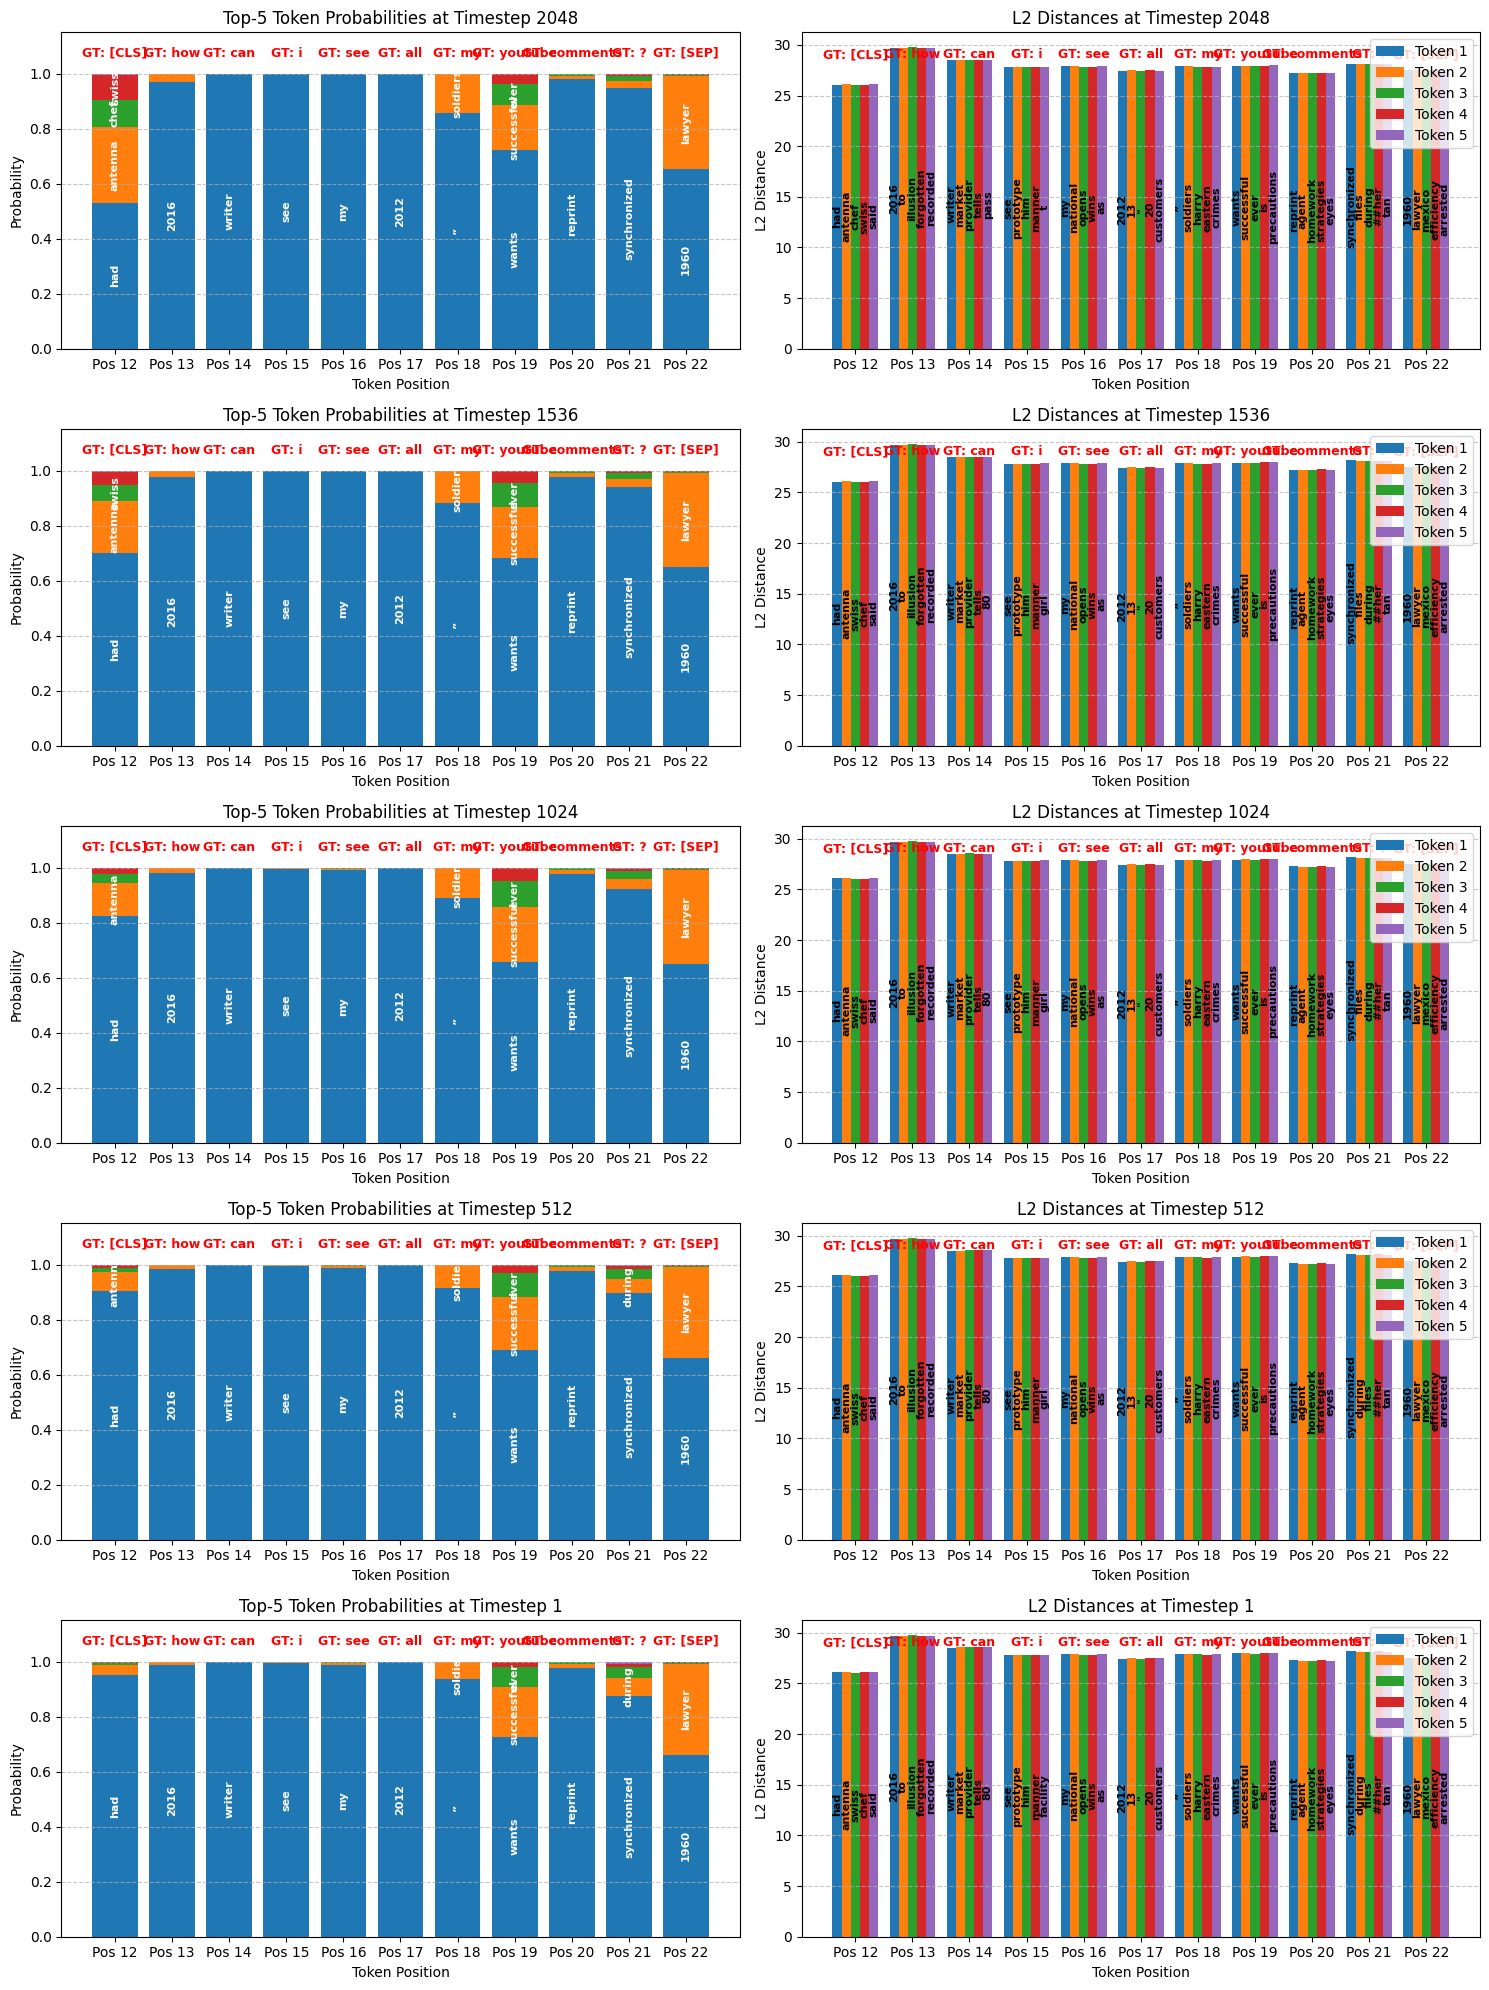


Top tokens at the final timestep (1):
Position 12 (Ground truth: [CLS]):
  1. had (prob: 0.9502)
  2. antenna (prob: 0.0372)
  3. swiss (prob: 0.0076)
  4. chef (prob: 0.0036)
  5. said (prob: 0.0011)

Position 13 (Ground truth: how):
  1. 2016 (prob: 0.9890)
  2. to (prob: 0.0109)
  3. illusion (prob: 0.0000)
  4. forgotten (prob: 0.0000)
  5. recorded (prob: 0.0000)

Position 14 (Ground truth: can):
  1. writer (prob: 1.0000)
  2. market (prob: 0.0000)
  3. provider (prob: 0.0000)
  4. tells (prob: 0.0000)
  5. 80 (prob: 0.0000)

Position 15 (Ground truth: i):
  1. see (prob: 0.9959)
  2. prototype (prob: 0.0023)
  3. him (prob: 0.0011)
  4. manner (prob: 0.0007)
  5. facility (prob: 0.0000)

Position 16 (Ground truth: see):
  1. my (prob: 0.9888)
  2. national (prob: 0.0074)
  3. opens (prob: 0.0030)
  4. wins (prob: 0.0003)
  5. as (prob: 0.0001)

Position 17 (Ground truth: all):
  1. 2012 (prob: 0.9999)
  2. 13 (prob: 0.0001)
  3. " (prob: 0.0000)
  4. 20 (prob: 0.0000)
  5. cust

In [3]:

# Set parameters
shortcut_size = 1024
top_k = 5
example_idx = 0

# Run analysis without saving figures
token_results = analyze_token_predictions(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx,
    save_path=None  # Set to None to not save figures
)

## Analyze Multiple Examples



Analyzing example 0...
Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


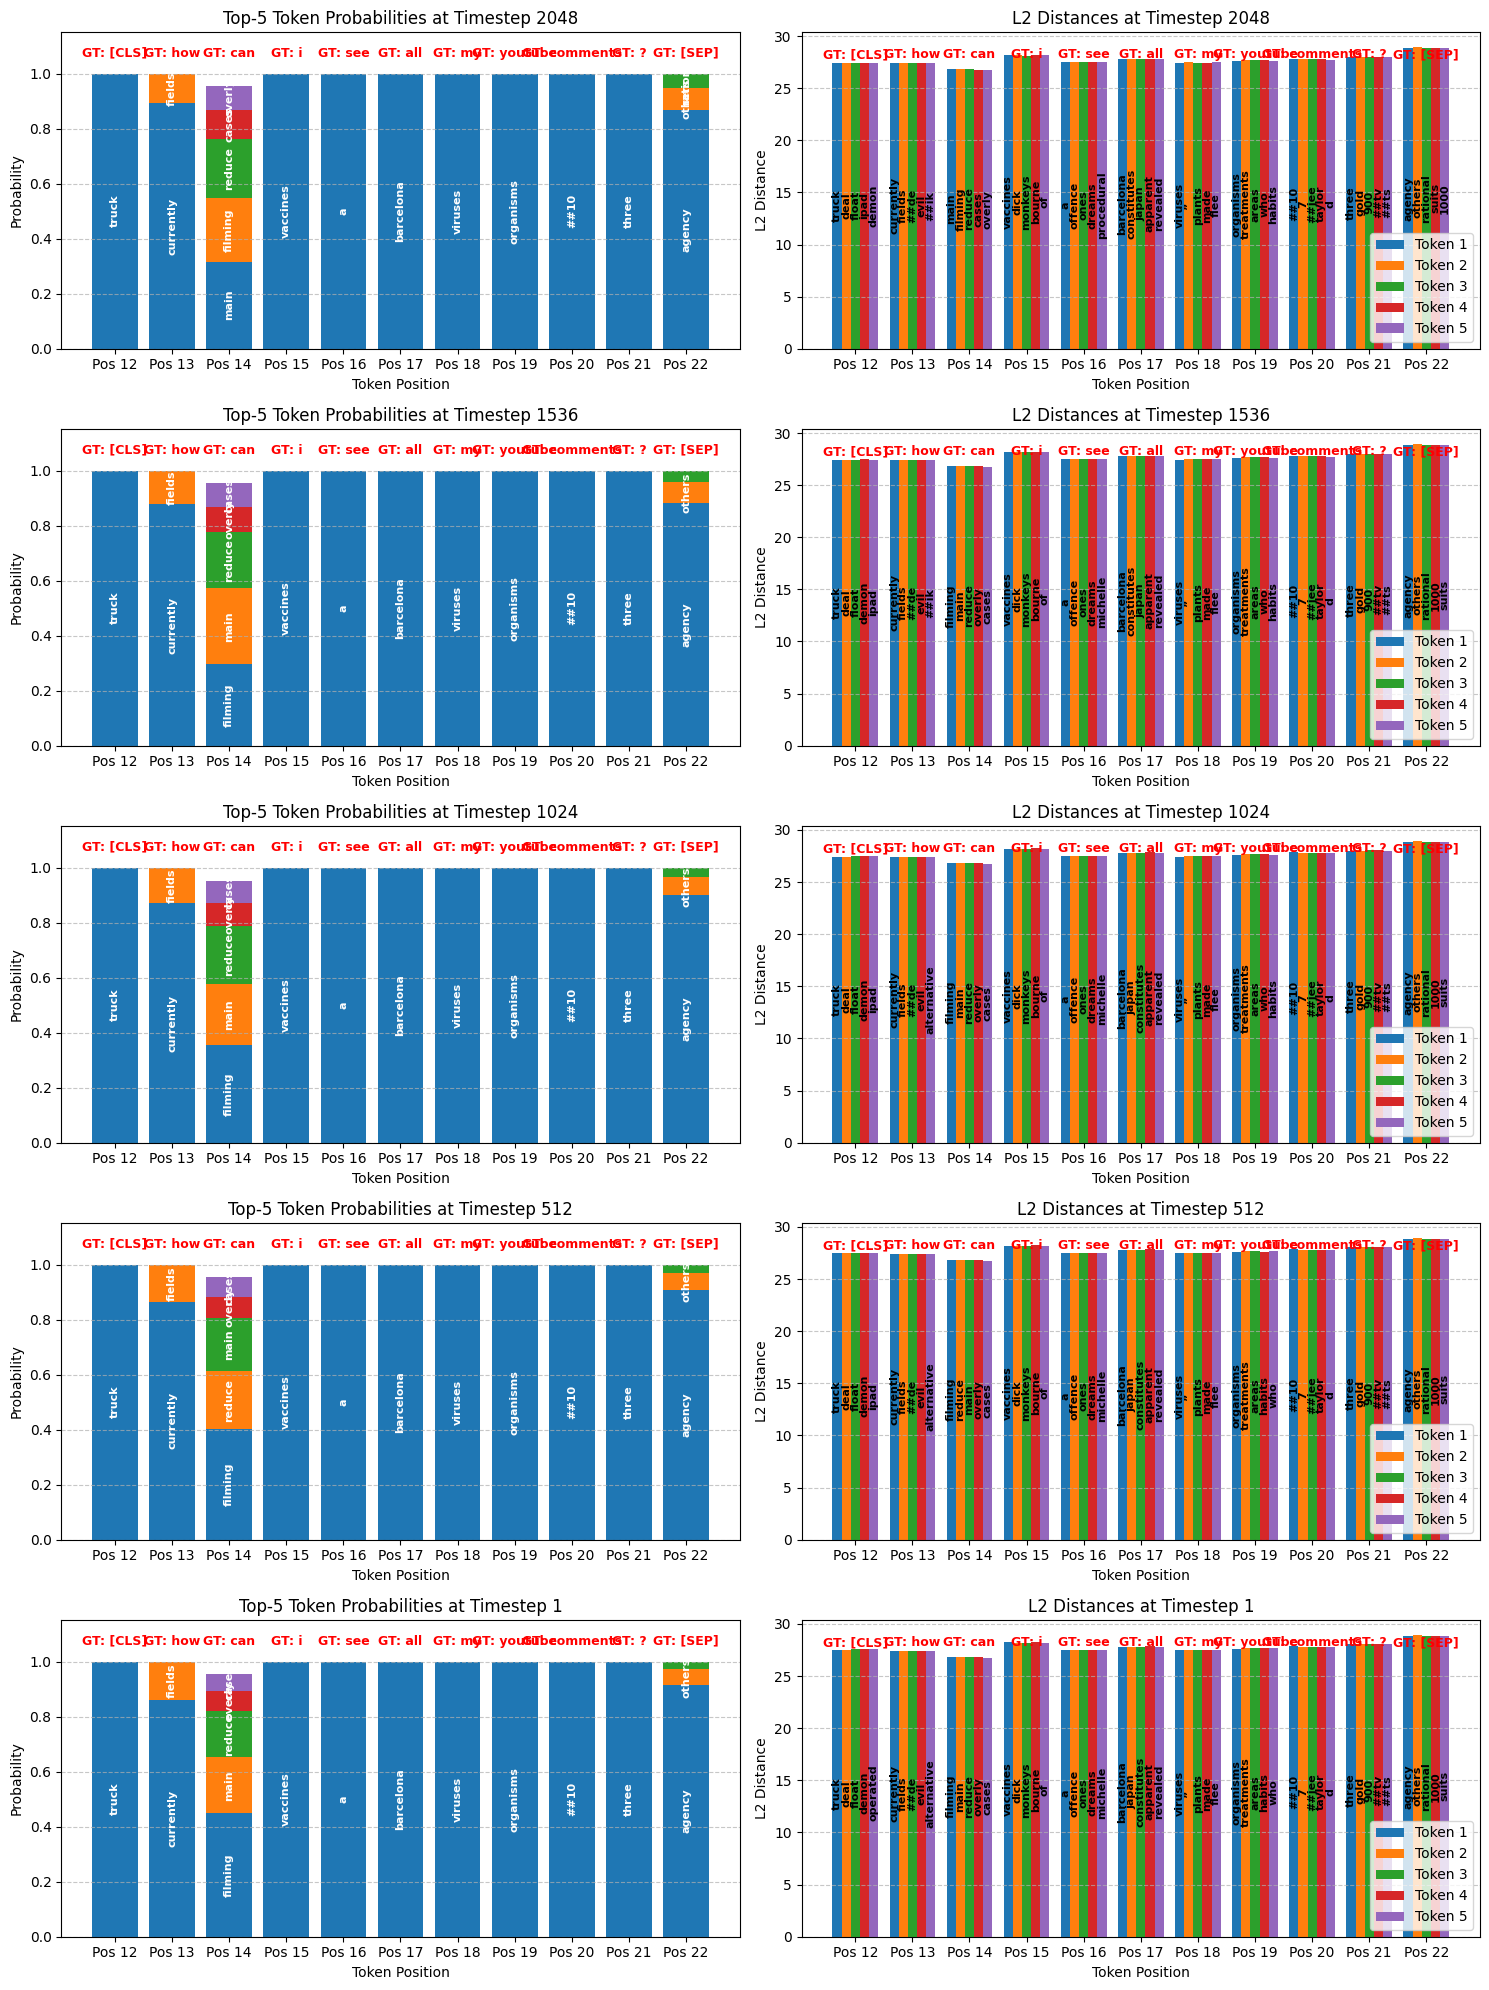


Top tokens at the final timestep (1):
Position 12 (Ground truth: [CLS]):
  1. truck (prob: 1.0000)
  2. deal (prob: 0.0000)
  3. float (prob: 0.0000)
  4. demon (prob: 0.0000)
  5. operated (prob: 0.0000)

Position 13 (Ground truth: how):
  1. currently (prob: 0.8596)
  2. fields (prob: 0.1394)
  3. ##de (prob: 0.0010)
  4. evil (prob: 0.0000)
  5. alternative (prob: 0.0000)

Position 14 (Ground truth: can):
  1. filming (prob: 0.4493)
  2. main (prob: 0.2022)
  3. reduce (prob: 0.1701)
  4. overly (prob: 0.0721)
  5. cases (prob: 0.0594)

Position 15 (Ground truth: i):
  1. vaccines (prob: 1.0000)
  2. dick (prob: 0.0000)
  3. monkeys (prob: 0.0000)
  4. bourne (prob: 0.0000)
  5. of (prob: 0.0000)

Position 16 (Ground truth: see):
  1. a (prob: 0.9996)
  2. offence (prob: 0.0003)
  3. ones (prob: 0.0001)
  4. dreams (prob: 0.0000)
  5. michelle (prob: 0.0000)

Position 17 (Ground truth: all):
  1. barcelona (prob: 1.0000)
  2. japan (prob: 0.0000)
  3. constitutes (prob: 0.0000)
  4

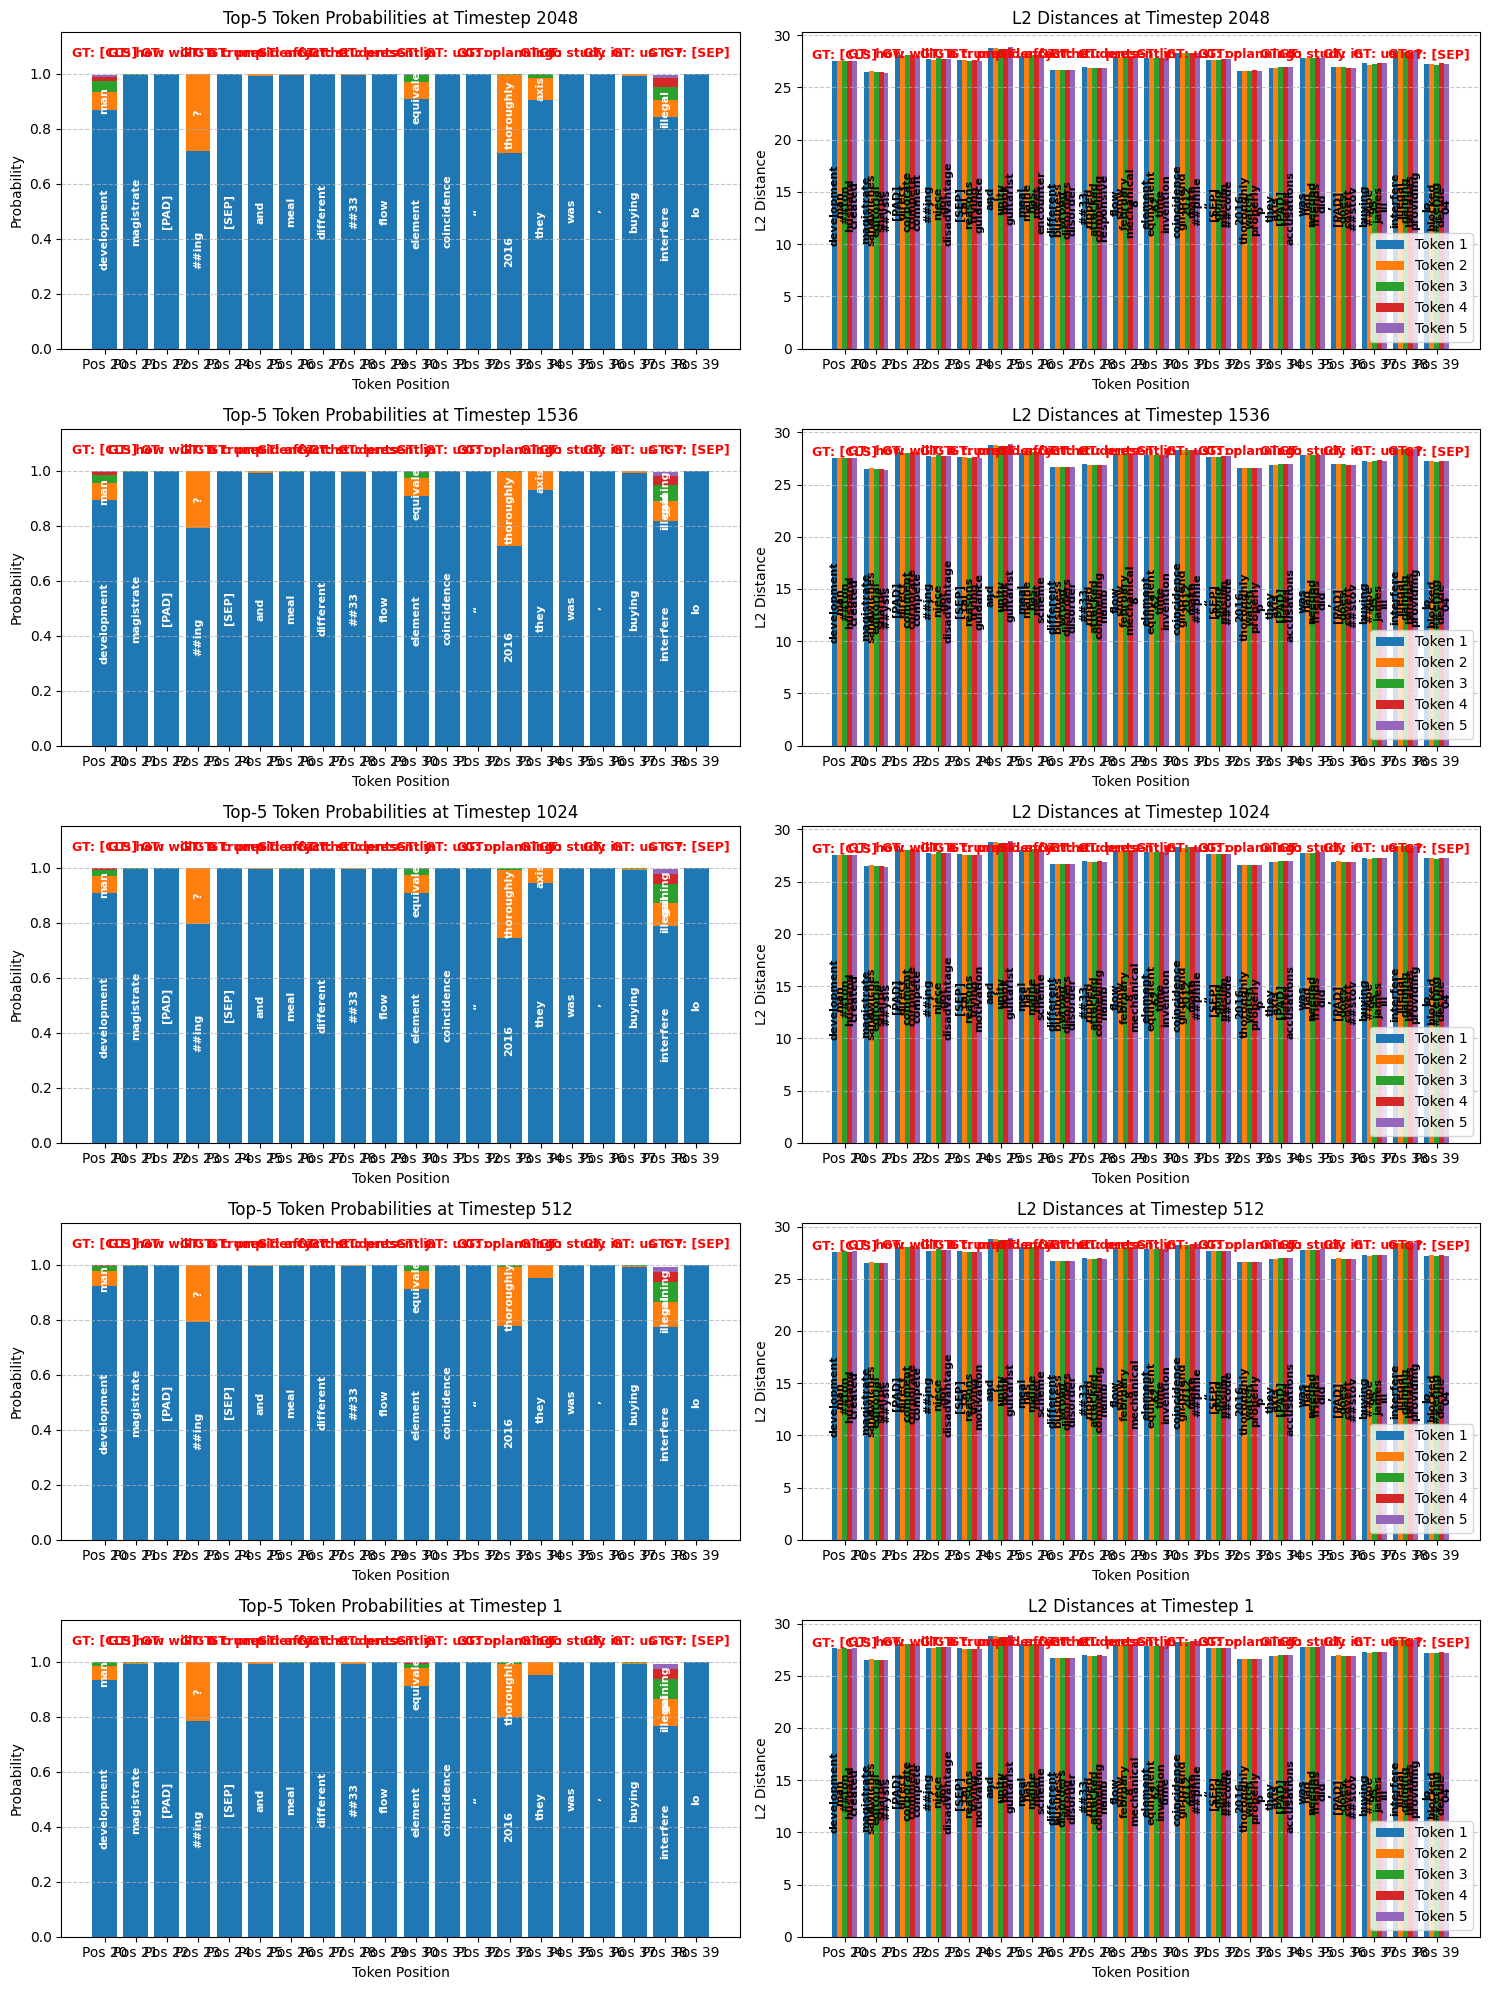


Top tokens at the final timestep (1):
Position 20 (Ground truth: [CLS]):
  1. development (prob: 0.9320)
  2. man (prob: 0.0513)
  3. ##ton (prob: 0.0136)
  4. husband (prob: 0.0023)
  5. created (prob: 0.0005)

Position 21 (Ground truth: how):
  1. magistrate (prob: 0.9927)
  2. sandwiches (prob: 0.0024)
  3. editorial (prob: 0.0018)
  4. sharpe (prob: 0.0014)
  5. ##ysis (prob: 0.0013)

Position 22 (Ground truth: will):
  1. [PAD] (prob: 1.0000)
  2. direct (prob: 0.0000)
  3. corporate (prob: 0.0000)
  4. comment (prob: 0.0000)
  5. compete (prob: 0.0000)

Position 23 (Ground truth: a):
  1. ##ing (prob: 0.7848)
  2. ? (prob: 0.2132)
  3. niece (prob: 0.0020)
  4. got (prob: 0.0000)
  5. disadvantage (prob: 0.0000)

Position 24 (Ground truth: trump):
  1. [SEP] (prob: 1.0000)
  2. cal (prob: 0.0000)
  3. reasons (prob: 0.0000)
  4. trying (prob: 0.0000)
  5. motivation (prob: 0.0000)

Position 25 (Ground truth: presidency):
  1. and (prob: 0.9924)
  2. ? (prob: 0.0066)
  3. unity (

In [ ]:
# Analyze multiple examples
for i in range(3):  # Analyze first 3 examples
    print(f"\n\nAnalyzing example {i}...")
    token_results = analyze_token_predictions(
        unit,
        test_batch,
        shortcut_size,
        top_k=top_k,
        example_idx=i,
        save_path=None
    )

## Customize Visualization

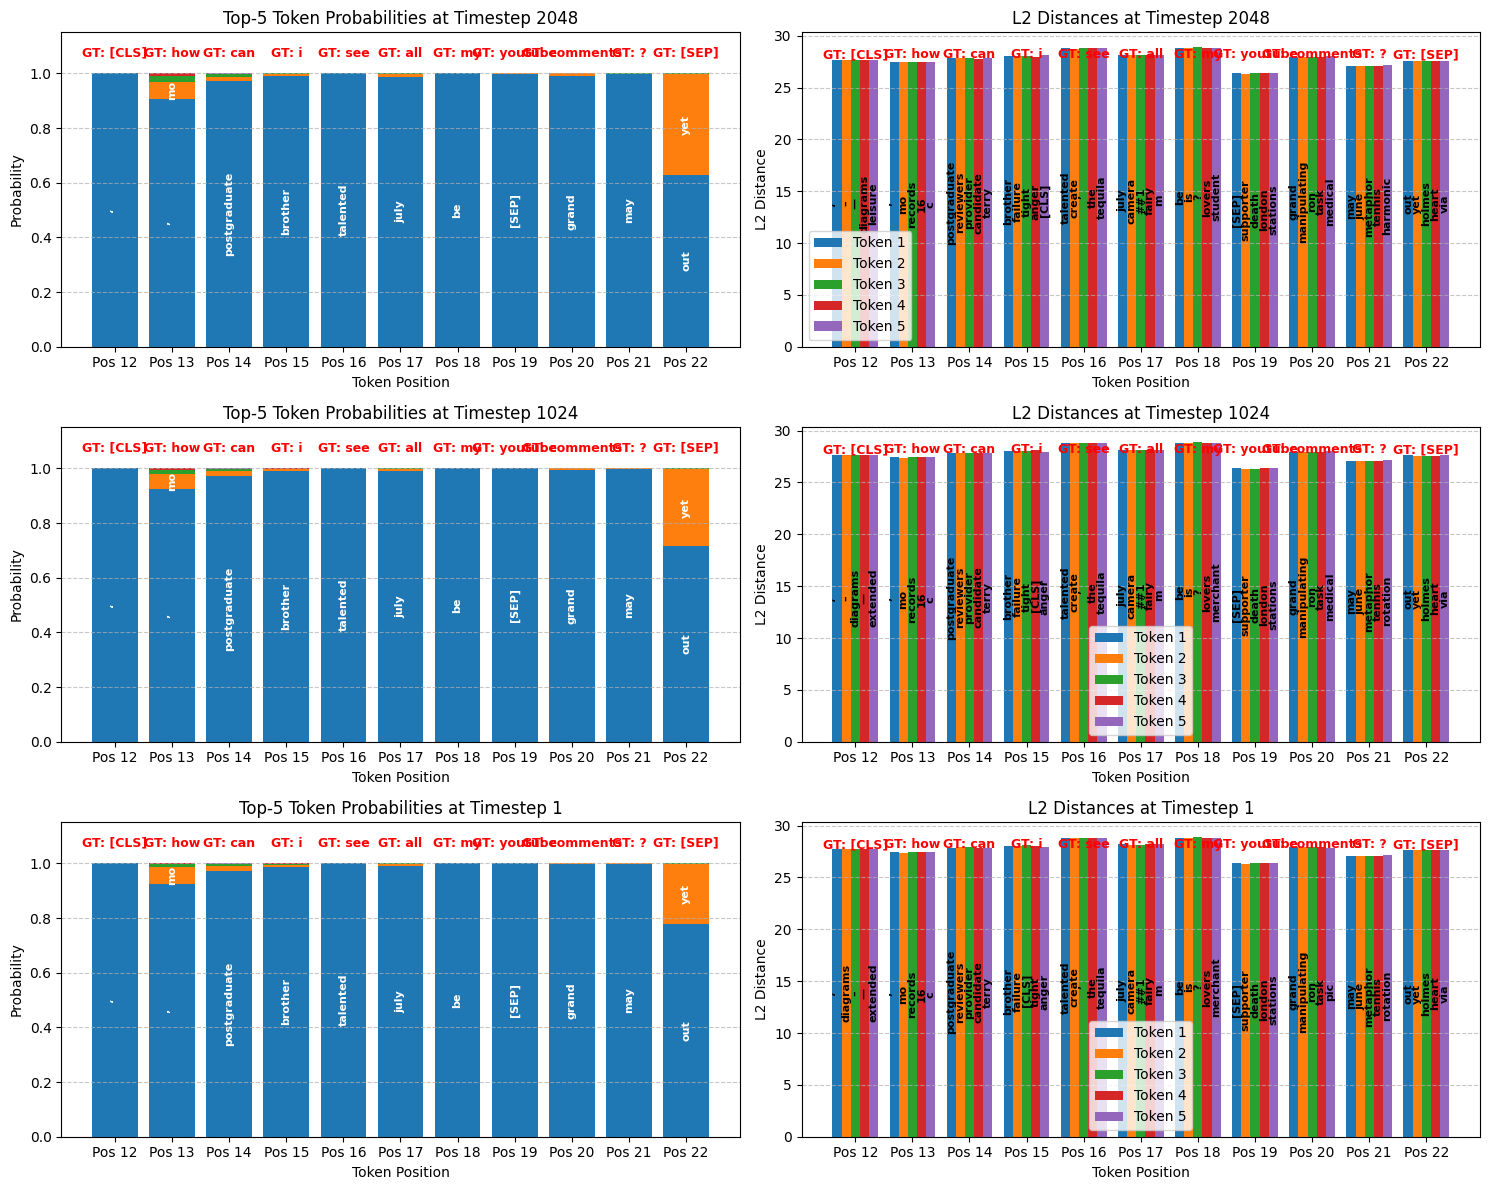

In [6]:

# Run denoising with token tracking
token_results = denoise_with_token_tracking(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx
)

# Select specific timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)
timestep_indices = [0, num_steps // 2, num_steps - 1]  # First, middle, last

# Customize figure size
figsize = (15, 12)

# Visualize the selected timesteps
visualize_top_k_tokens(
    token_results,
    timestep_indices=timestep_indices,
    figsize=figsize,
    save_path=None
)

## Save Figures

Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


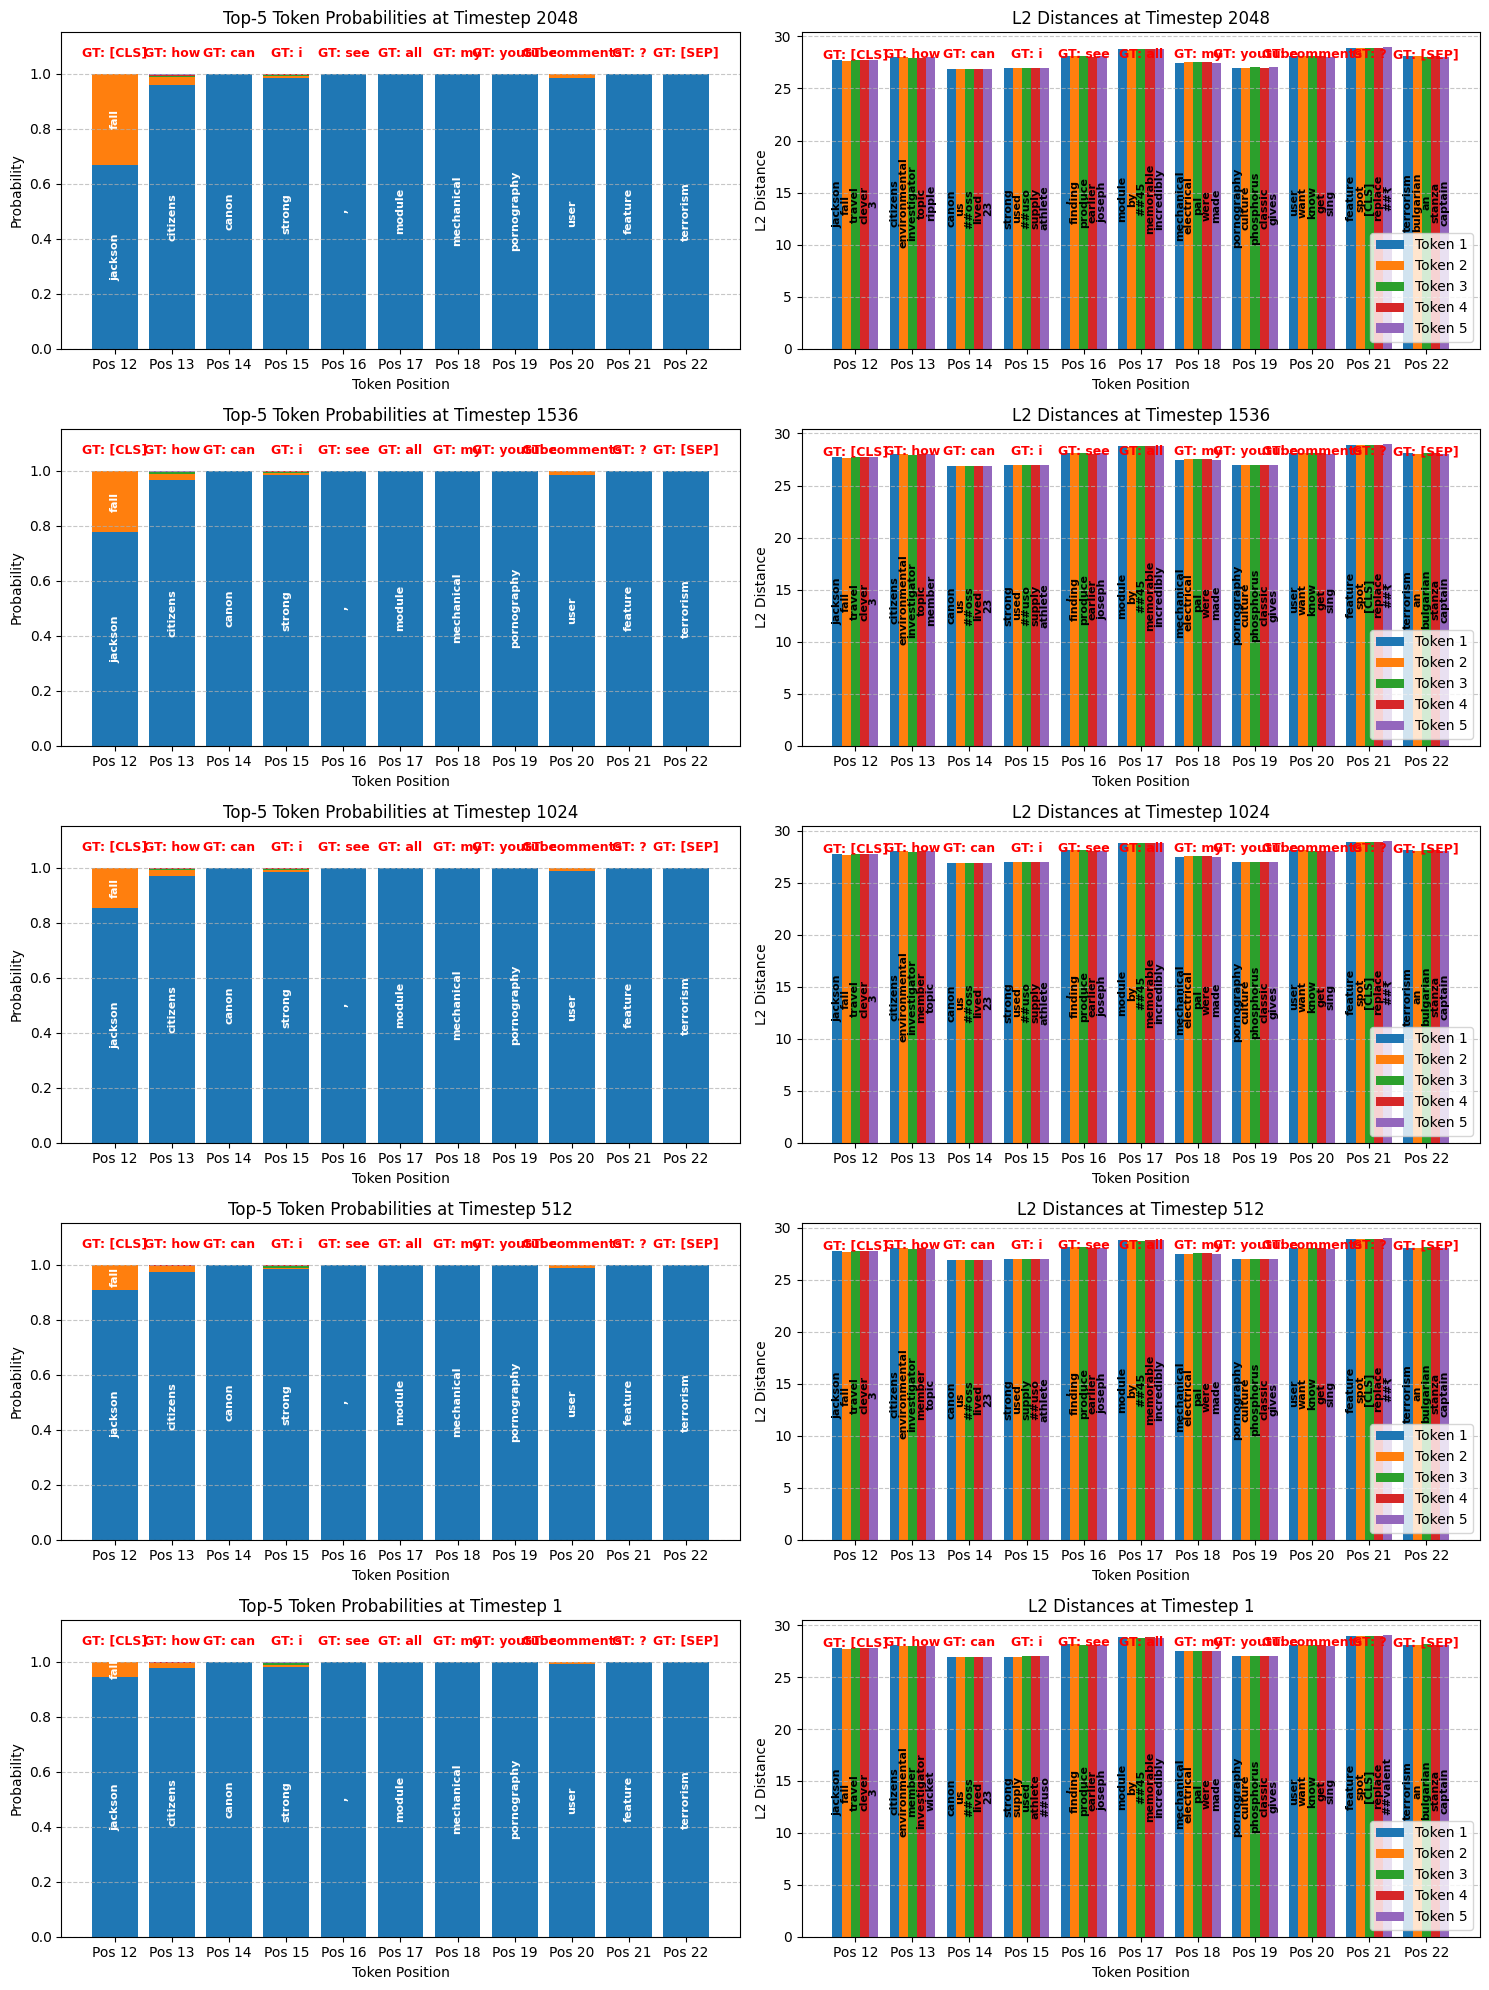


Top tokens at the final timestep (1):
Position 12 (Ground truth: [CLS]):
  1. jackson (prob: 0.9434)
  2. fall (prob: 0.0563)
  3. travel (prob: 0.0002)
  4. clever (prob: 0.0000)
  5. 3 (prob: 0.0000)

Position 13 (Ground truth: how):
  1. citizens (prob: 0.9755)
  2. environmental (prob: 0.0184)
  3. member (prob: 0.0026)
  4. investigator (prob: 0.0017)
  5. wicket (prob: 0.0005)

Position 14 (Ground truth: can):
  1. canon (prob: 0.9994)
  2. us (prob: 0.0005)
  3. ##oss (prob: 0.0001)
  4. lived (prob: 0.0000)
  5. 23 (prob: 0.0000)

Position 15 (Ground truth: i):
  1. strong (prob: 0.9802)
  2. supply (prob: 0.0075)
  3. used (prob: 0.0058)
  4. athlete (prob: 0.0031)
  5. ##uso (prob: 0.0027)

Position 16 (Ground truth: see):
  1. , (prob: 1.0000)
  2. finding (prob: 0.0000)
  3. produce (prob: 0.0000)
  4. earlier (prob: 0.0000)
  5. joseph (prob: 0.0000)

Position 17 (Ground truth: all):
  1. module (prob: 0.9999)
  2. by (prob: 0.0001)
  3. ##45 (prob: 0.0000)
  4. memorable

In [8]:
# Create output directory
output_dir = "../reports/figures"
os.makedirs(output_dir, exist_ok=True)

# Run analysis and save figure
output_path = os.path.join(output_dir, f"token_analysis_example_{example_idx}.png")
token_results = analyze_token_predictions(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx,
    save_path=output_path
)

print(f"Figure saved to {output_path}")